hog_vector (1995, 36)
hog_image (295, 466)


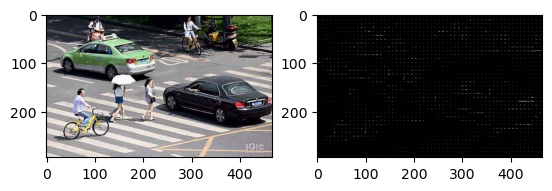

Save hog_image to: hog_images\0dd20243-8.jpg
hog_vector (1760, 36)
hog_image (266, 450)


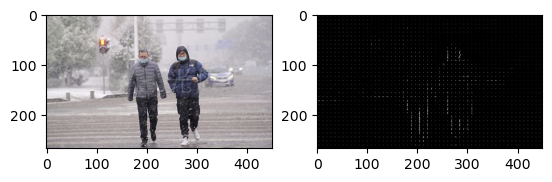

Save hog_image to: hog_images\16bf9a67-0.jpg
hog_vector (1683, 36)
hog_image (277, 417)


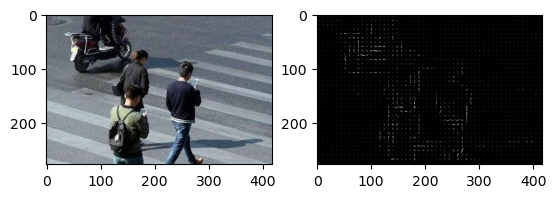

Save hog_image to: hog_images\796ec187-7.jpg
hog_vector (1749, 36)
hog_image (277, 439)


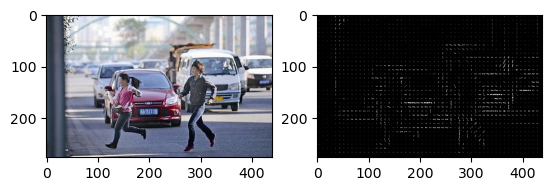

Save hog_image to: hog_images\9a07eb57-6.jpg
hog_vector (1785, 36)
hog_image (295, 421)


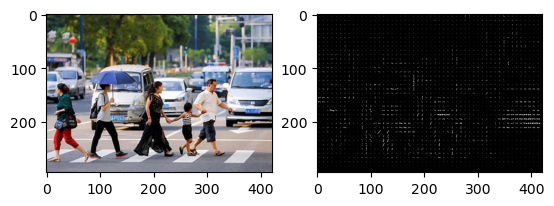

Save hog_image to: hog_images\ad3956f8-9.jpg
hog_vector (5985, 36)
hog_image (513, 770)


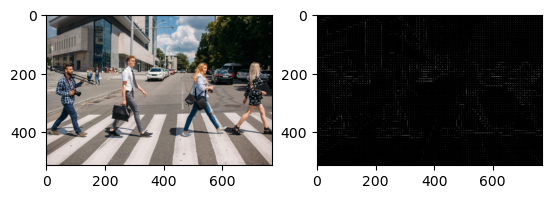

Save hog_image to: hog_images\b2dd240c-2.jpg
hog_vector (10168, 36)
hog_image (667, 1000)


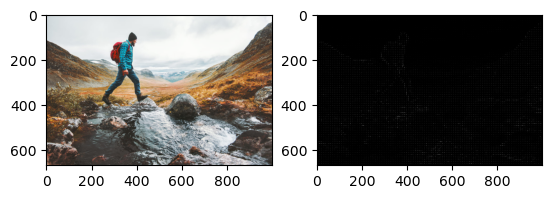

Save hog_image to: hog_images\b71184b9-1.jpg
hog_vector (41085, 36)
hog_image (1332, 2000)


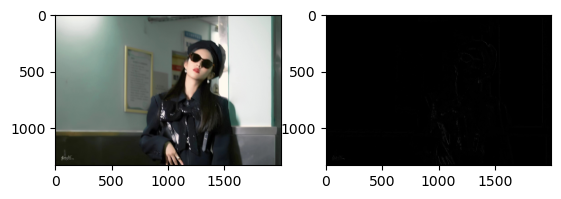

Save hog_image to: hog_images\c1c0fe3c-4.jpg
hog_vector (1856, 36)
hog_image (265, 475)


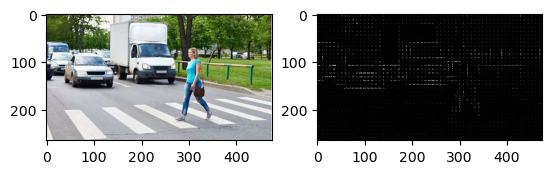

Save hog_image to: hog_images\d9a9c2fa-5.jpg
hog_vector (28928, 36)
hog_image (1032, 1822)


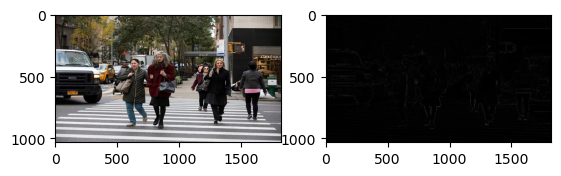

Save hog_image to: hog_images\e628b968-3.jpg


In [5]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 24 18:23:04 2018

@author: zy
"""

#代码来源GitHub:https://github.com/PENGZhaoqing/Hog-feature
#https://blog.csdn.net/ppp8300885/article/details/71078555
#https://www.leiphone.com/news/201708/ZKsGd2JRKr766wEd.html

import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


class Hog_descriptor():
    '''
    Implementation of HOG Descriptor
    '''
    def __init__(self, img, cell_size=8, bin_size=9):
        '''
        Constructor
            Default parameters: one block consists of 2x2 cells, and the stride is 1 cell size
        args:
            img: input image (more accurately, the detection window), which should be a grayscale image.
                For pedestrian detection, the image size is generally 128x64, which is a small cropped region from the input image.
            cell_size: size of the cell, e.g., 8 means 8x8 pixels.
            bin_size: number of bins in the histogram.
        '''
        self.img = img
        '''
        Apply Gamma correction to the input image for color space normalization (standardization),
        which aims to adjust the image contrast, reduce the impact of local shadows and lighting changes,
        and suppress noise. The gamma value used here is 0.5. f(I) = I^γ
        '''
        self.img = np.sqrt(img*1.0 / float(np.max(img)))
        self.img = self.img * 255
        #print('img',self.img.dtype)   #float64
        # Parameter initialization
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.angle_unit = 180 / self.bin_size  # Here, 180° is used
        assert type(self.bin_size) == int, "bin_size should be an integer,"
        assert type(self.cell_size) == int, "cell_size should be an integer,"
        assert 180 % self.bin_size == 0, "bin_size should be divisible by 180"

    def extract(self):
        '''
        计算图像的HOG描述符, 以及HOG-image特征图
        '''
        height, width = self.img.shape

        '''
        1. Calculate the gradient magnitude and angle for each pixel in the image
        '''
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)    #确保每个像素点的梯度幅度都为正值，如果幅度是负数，将导致方向直方图的权重错误，影响最终的特征提取效果。
        '''
        2. Calculate the gradient histogram for each cell in the input image to form the descriptor of each cell.
           For example, if the input image is 128x64, you can get 16x8 cells, and each cell consists of 9 bins.
        '''
        cell_gradient_vector = np.zeros((int(height / self.cell_size), int(width / self.cell_size), self.bin_size))
        # Traverse each row and each column
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                # Calculate the feature vector of the [i][j] cell
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)


        # Plot the gradient orientation histogram of each cell to obtain the feature map
        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        
        '''
        3. Form a block using 2x2 cells, concatenate the features of all cells within a block to obtain the HOG feature descriptor of that block.
           Concatenate the HOG feature descriptors of all blocks within the image to obtain the HOG feature descriptor of the image (detection target).
           This is the final feature vector for classification.
        '''
        hog_vector = []
        # Default stride is the size of one cell, one block consists of 2x2 cells, traverse each block
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                # Extract the feature vector of the [i][j] block
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                '''Normalize the gradient histograms within the block to remove changes in lighting, shadow, etc., and increase robustness'''
                # Calculate L2 norm
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))   
                magnitude = mag(block_vector) + 1e-5
                # Normalize
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)           
        return np.asarray(hog_vector), hog_image

    def global_gradient(self):
        '''
        Calculate the gradients of the image along the x-axis and y-axis separately
        '''
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)  # 使用Sobel算子计算水平和垂直方向的梯度
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        # Calculate the gradient magnitude and gradient angle
        gradient_magnitude, gradient_angle = cv2.cartToPolar(gradient_values_x, gradient_values_y, angleInDegrees=True)        
        # Subtract 180 degrees from angles greater than 180°
        gradient_angle[gradient_angle > 180.0] -= 180 
        return gradient_magnitude, gradient_angle


    def cell_gradient(self, cell_magnitude, cell_angle):
        '''
        Build a gradient orientation histogram for each cell
        
        args:
            cell_magnitude: gradient magnitude of each pixel in the cell
            cell_angle: gradient direction of each pixel in the cell
        return:
            Returns the gradient histogram corresponding to the cell, with a length of bin_size
        '''
        orientation_centers = [0] * self.bin_size
        # Traverse each pixel in the cell
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                # Gradient magnitude
                gradient_strength = cell_magnitude[i][j]
                # Gradient direction
                gradient_angle = cell_angle[i][j]
                # Bilinear interpolation
                min_angle, max_angle, weight = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - weight))
                orientation_centers[max_angle] += (gradient_strength * weight)
        return orientation_centers

    def get_closest_bins(self, gradient_angle):
        '''
        例如: 当我们把180°划分为9个bin的时候, 分别对应对应0,20,40,...160这些角度。
              角度是10,副值是4,因为角度10介于0-20度的中间(正好一半)，所以把幅值
              一分为二地放到0和20两个bin里面去。
        args:
            gradient_angle:角度
        return:
            start,end,weight: 起始bin索引,终止bin的索引,end索引对应bin所占权重
        '''
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        return idx % self.bin_size, (idx + 1) % self.bin_size, mod / self.angle_unit


    def render_gradient(self, image, cell_gradient):
        '''
        Plot the gradient orientation histogram of each cell to obtain the feature map.
        
        Args:
            image: Canvas, same size as the input image [h, w]
            cell_gradient: Gradient histograms for each cell of the input image, shape [h/cell_size, w/cell_size, bin_size]
        Returns:
            image: Feature map
        '''
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        # Traverse each cell
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                # Get the gradient histogram of the [x][y] cell
                cell_grad = cell_gradient[x][y]
                # Normalize
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                # Traverse each bin
                for magnitude in cell_grad:
                    # Convert to radians
                    angle_radian = math.radians(angle)
                    # Calculate start and end coordinates. The length is proportional to the magnitude (normalized), 
                    # with larger magnitudes resulting in longer and brighter lines.
                    x1 = int(x * self.cell_size + cell_width + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + cell_width + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size + cell_width - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size + cell_width - magnitude * cell_width * math.sin(angle_radian))
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
        return image

        
if __name__ == '__main__':
    # Load image
    image_folder = 'images'
    for image_filename in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_filename)
        img = cv2.imread(image_path)
        if img is None:
            print('Failed to load image file:', image_path)
            sys.exit(1)
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # HOG feature extraction
        hog = Hog_descriptor(gray, cell_size=8, bin_size=9)
        hog_vector, hog_image = hog.extract()
        print('hog_vector', hog_vector.shape)
        print('hog_image', hog_image.shape)
        # Plot feature map
        plt.figure(figsize=(6.4, 2.0 * 3.2))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.subplot(1, 2, 2)
        plt.imshow(hog_image, cmap=plt.cm.gray)
        # 原图和HOG拼接保存
        plt.savefig('hog_images/hog_image_'+image_filename
                    , bbox_inches='tight', pad_inches=0.0)
        plt.show()
        # Save feature map
        hog_image_folder = 'hog_images'
        if not os.path.exists(hog_image_folder):
            os.makedirs(hog_image_folder)
        hog_image_path = os.path.join('hog_images', image_filename)
        cv2.imwrite(hog_image_path, hog_image)
        print('Save hog_image to:', hog_image_path)

